# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
%load_ext autoreload
%autoreload 2

from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
from collections import deque
import matplotlib.pyplot as plt
from ddpg_agent import Agent
import torch
import time
import pickle

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [13]:
def ddpg(n_episodes=10000, max_steps=3000, learn_interval = 10, 
         learn_repeats = 5, target_score = 0.5):
    scores_deque = deque(maxlen=100)
    running_scores = []
    average_score = []
    
    # instantiates agent from environment data
    agent = Agent(state_size=state_size, action_size=action_size, random_seed=7)

    for i_episode in range(1, n_episodes+1):
        # log the start time to calculate the episode period
        start_time = time.time()
        
        # reset the environment between episodes
        env_info = env.reset(train_mode=True)[brain_name]
        
        # get the first state
        states = env_info.vector_observations

        # reset the agent noise
        agent.reset()
        
        # reset scores
        scores = np.zeros(num_agents)
        
        for t in range(max_steps):
            # Gets agents net array of actions
            actions = agent.act(states)

            # send the actions to environment
            env_info = env.step(actions)[brain_name]
            
            # reads the next state
            next_states = env_info.vector_observations
            
            # reads the reward
            rewards = env_info.rewards
            
            # reads if the episode is finished
            dones = env_info.local_done
            
            # sends information from the 20 simulations to agent
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done)

            # update the state
            states = next_states
            
            # update the score
            scores += rewards
            
            # start a learning phase every learn_interval steps
            if t % learn_interval == 0:
                # train for learn_repeats cycles
                for i in range(learn_repeats):
                    agent.start_learn()
                
            
            # if the episode is done, the break
            if np.any(dones):
                break
 
        scores_deque.append(np.mean(scores))
        running_scores.append(np.mean(scores))
        average_score.append(np.mean(scores_deque))
        # display the current result
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}\tPeriod: {:.2f}s'.format(i_episode, np.mean(scores_deque), np.mean(scores), time.time() - start_time))
        
        # save the model every 50 steps
        if i_episode % 50 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            pickle.dump(agent.memory.memory, open( "memory.pickle", "wb" ) )
        
        # quit if we have reached the target
        if np.mean(scores_deque) >= target_score:
            print('Solved after {} epsisodes. Total Average score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            pickle.dump(agent.memory.memory, open( "memory.pickle", "wb" ) )
            break
    
    return running_scores, average_score

In [7]:
running_scores, average_score = ddpg()

C:\Users\david.ng\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 1	Average Score: -0.00	Score: -0.00	Period: 0.08s
Episode 2	Average Score: -0.00	Score: -0.00	Period: 0.87s
Episode 3	Average Score: -0.00	Score: -0.00	Period: 0.05s
Episode 4	Average Score: -0.00	Score: -0.00	Period: 0.04s
Episode 5	Average Score: 0.01	Score: 0.05	Period: 0.08s
Episode 6	Average Score: 0.00	Score: -0.00	Period: 0.04s
Episode 7	Average Score: 0.00	Score: -0.00	Period: 0.04s
Episode 8	Average Score: 0.00	Score: -0.00	Period: 0.03s
Episode 9	Average Score: 0.00	Score: -0.00	Period: 0.04s
Episode 10	Average Score: 0.00	Score: -0.00	Period: 0.03s
Episode 11	Average Score: -0.00	Score: -0.00	Period: 0.04s
Episode 12	Average Score: -0.00	Score: -0.00	Period: 0.03s
Episode 13	Average Score: -0.00	Score: -0.00	Period: 0.04s
Episode 14	Average Score: -0.00	Score: -0.00	Period: 0.03s
Episode 15	Average Score: 0.00	Score: 0.05	Period: 0.08s
Episode 16	Average Score: 0.00	Score: -0.00	Period: 0.32s
Episode 17	Average Score: 0.00	Score: -0.00	Period: 0.55s
Episode 18	Averag

Episode 140	Average Score: -0.00	Score: -0.00	Period: 0.46s
Episode 141	Average Score: -0.00	Score: -0.00	Period: 0.46s
Episode 142	Average Score: -0.00	Score: -0.00	Period: 0.46s
Episode 143	Average Score: -0.00	Score: -0.00	Period: 0.46s
Episode 144	Average Score: -0.00	Score: -0.00	Period: 0.47s
Episode 145	Average Score: -0.00	Score: -0.00	Period: 0.46s
Episode 146	Average Score: -0.00	Score: -0.00	Period: 0.46s
Episode 147	Average Score: -0.00	Score: -0.00	Period: 0.45s
Episode 148	Average Score: -0.00	Score: -0.00	Period: 0.46s
Episode 149	Average Score: -0.00	Score: -0.00	Period: 0.45s
Episode 150	Average Score: -0.00	Score: -0.00	Period: 0.44s
Episode 151	Average Score: -0.00	Score: -0.00	Period: 0.45s
Episode 152	Average Score: -0.00	Score: -0.00	Period: 0.45s
Episode 153	Average Score: -0.00	Score: -0.00	Period: 0.46s
Episode 154	Average Score: -0.00	Score: -0.00	Period: 0.45s
Episode 155	Average Score: -0.00	Score: -0.00	Period: 0.46s
Episode 156	Average Score: -0.00	Score: 

Episode 278	Average Score: 0.00	Score: -0.00	Period: 0.56s
Episode 279	Average Score: 0.00	Score: 0.05	Period: 1.19s
Episode 280	Average Score: 0.00	Score: 0.05	Period: 1.18s
Episode 281	Average Score: 0.00	Score: -0.00	Period: 0.59s
Episode 282	Average Score: 0.00	Score: -0.00	Period: 0.59s
Episode 283	Average Score: 0.00	Score: -0.00	Period: 0.59s
Episode 284	Average Score: 0.00	Score: -0.00	Period: 0.59s
Episode 285	Average Score: 0.00	Score: -0.00	Period: 0.58s
Episode 286	Average Score: 0.00	Score: -0.00	Period: 0.58s
Episode 287	Average Score: 0.00	Score: -0.00	Period: 0.58s
Episode 288	Average Score: 0.00	Score: -0.00	Period: 0.60s
Episode 289	Average Score: 0.00	Score: -0.00	Period: 0.58s
Episode 290	Average Score: 0.01	Score: 0.25	Period: 2.67s
Episode 291	Average Score: 0.01	Score: -0.00	Period: 0.65s
Episode 292	Average Score: 0.01	Score: -0.00	Period: 0.55s
Episode 293	Average Score: 0.01	Score: -0.00	Period: 0.52s
Episode 294	Average Score: 0.01	Score: -0.00	Period: 0.57s


Episode 419	Average Score: 0.07	Score: 0.05	Period: 0.92s
Episode 420	Average Score: 0.07	Score: 0.05	Period: 1.69s
Episode 421	Average Score: 0.08	Score: 0.25	Period: 3.13s
Episode 422	Average Score: 0.08	Score: 0.10	Period: 1.72s
Episode 423	Average Score: 0.08	Score: 0.30	Period: 3.71s
Episode 424	Average Score: 0.08	Score: 0.10	Period: 1.68s
Episode 425	Average Score: 0.09	Score: 0.65	Period: 7.98s
Episode 426	Average Score: 0.09	Score: 0.10	Period: 1.68s
Episode 427	Average Score: 0.09	Score: 0.15	Period: 1.99s
Episode 428	Average Score: 0.09	Score: 0.15	Period: 2.00s
Episode 429	Average Score: 0.09	Score: 0.30	Period: 3.77s
Episode 430	Average Score: 0.09	Score: 0.15	Period: 2.58s
Episode 431	Average Score: 0.09	Score: -0.00	Period: 0.56s
Episode 432	Average Score: 0.09	Score: 0.10	Period: 2.59s
Episode 433	Average Score: 0.09	Score: -0.00	Period: 0.59s
Episode 434	Average Score: 0.09	Score: 0.10	Period: 1.74s
Episode 435	Average Score: 0.09	Score: 0.05	Period: 0.84s
Episode 436	

Episode 560	Average Score: 0.28	Score: 0.10	Period: 1.39s
Episode 561	Average Score: 0.28	Score: 0.05	Period: 0.88s
Episode 562	Average Score: 0.28	Score: 0.15	Period: 1.54s
Episode 563	Average Score: 0.28	Score: 0.15	Period: 1.49s
Episode 564	Average Score: 0.28	Score: -0.00	Period: 0.43s
Episode 565	Average Score: 0.28	Score: 0.65	Period: 6.08s
Episode 566	Average Score: 0.27	Score: 0.05	Period: 1.54s
Episode 567	Average Score: 0.27	Score: 0.20	Period: 3.07s
Episode 568	Average Score: 0.27	Score: -0.00	Period: 0.48s
Episode 569	Average Score: 0.27	Score: 0.25	Period: 2.80s
Episode 570	Average Score: 0.27	Score: 0.05	Period: 1.46s
Episode 571	Average Score: 0.28	Score: 1.05	Period: 12.21s
Episode 572	Average Score: 0.28	Score: 0.30	Period: 2.45s
Episode 573	Average Score: 0.28	Score: 0.10	Period: 1.34s
Episode 574	Average Score: 0.28	Score: 0.20	Period: 2.00s
Episode 575	Average Score: 0.28	Score: 0.05	Period: 0.67s
Episode 576	Average Score: 0.29	Score: 0.90	Period: 10.51s
Episode 57

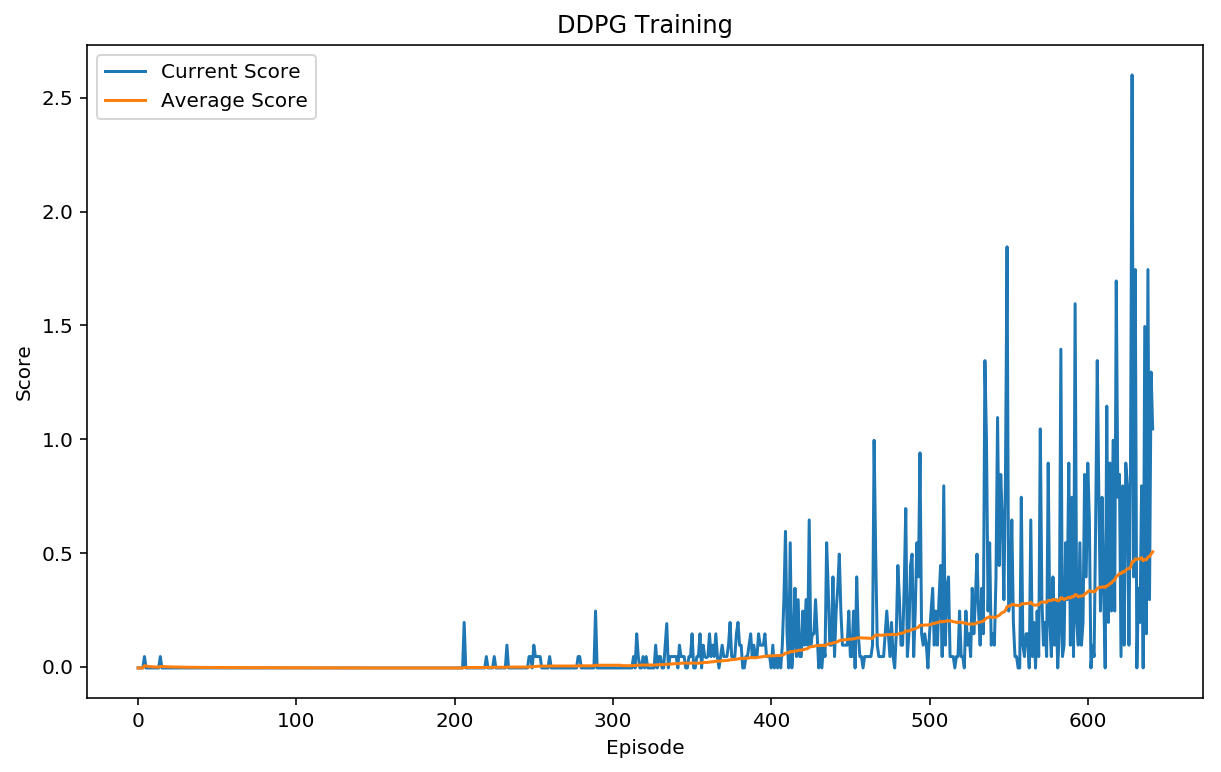

In [8]:
fig = plt.figure(figsize=(10,6))

plt.plot(running_scores, label='Current Score')
plt.plot(average_score, label='Average Score')
plt.title('DDPG Training')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.legend()
plt.show()

### 3. Use the trained DDPG to demo the robots

In the next code cell, we load the 'memories' of the training into the model, and then run the network.
This way we can generate a movie of the actions of the trained system.

In [24]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment 

# set up agent and load memories
agent = Agent(state_size=state_size, action_size=action_size, random_seed=7)
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))


states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
for i_ticks in range(1000):
    # Gets agents net array of actions
    actions = agent.act(states)

    # send the actions to environment
    env_info = env.step(actions)[brain_name]

    next_states = env_info.vector_observations         # get next state (for each agent)
    states = next_states                               # roll over states to next time step

When finished, you can close the environment.

In [ ]:
env.close()